# Time Series LSTM Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [2]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display

**Initiate bound between MetaTrader5 and Python**

In [4]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [5]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262,30,0
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599,30,0
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832,30,0
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761,30,0
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484,30,0


In [6]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484


## Feature engineering 
**Creating new input variables from raw data**

In [8]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,120.39,NaN
2015-01-02 09:00:00,120.43,0.000332
2015-01-02 10:00:00,120.34,-0.000747
2015-01-02 11:00:00,120.40,0.000499
2015-01-02 12:00:00,120.43,0.000249


In [9]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-06 20:00:00,118.36,-0.001013,118.910667,119.814667,0.308300,0.423147,37.046534,-72.670807
2015-01-06 21:00:00,118.62,0.002197,118.848667,119.780833,0.340361,0.415715,36.030372,-79.746835
2015-01-06 22:00:00,118.49,-0.001096,118.808000,119.750667,0.342922,0.409160,39.735411,-60.273973
2015-01-06 23:00:00,118.36,-0.001097,118.777333,119.719833,0.343455,0.420124,38.579643,-69.178082
2015-01-07 00:00:00,118.59,0.001943,118.748667,119.685833,0.283706,0.431128,37.452708,-77.142857


In [10]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Check the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-07 01:00:00,118.65,0.000506,118.710667,119.655167,0.240289,0.425081,40.626936,-60.714286,118.59,118.36,118.49,118.62,118.36
2015-01-07 02:00:00,118.74,0.000759,118.696000,119.624833,0.192841,0.416137,41.429091,-54.477612,118.65,118.59,118.36,118.49,118.62
2015-01-07 03:00:00,119.00,0.002190,118.690000,119.593500,0.172784,0.397710,42.631784,-47.761194,118.74,118.65,118.59,118.36,118.49
2015-01-07 04:00:00,119.06,0.000504,118.692667,119.566833,0.225657,0.383160,45.948689,-28.358209,119.00,118.74,118.65,118.59,118.36
2015-01-07 05:00:00,119.01,-0.000420,118.676000,119.539833,0.241212,0.360198,46.684583,-23.880597,119.06,119.00,118.74,118.65,118.59


## Implementing Machine Learning

In [3001]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

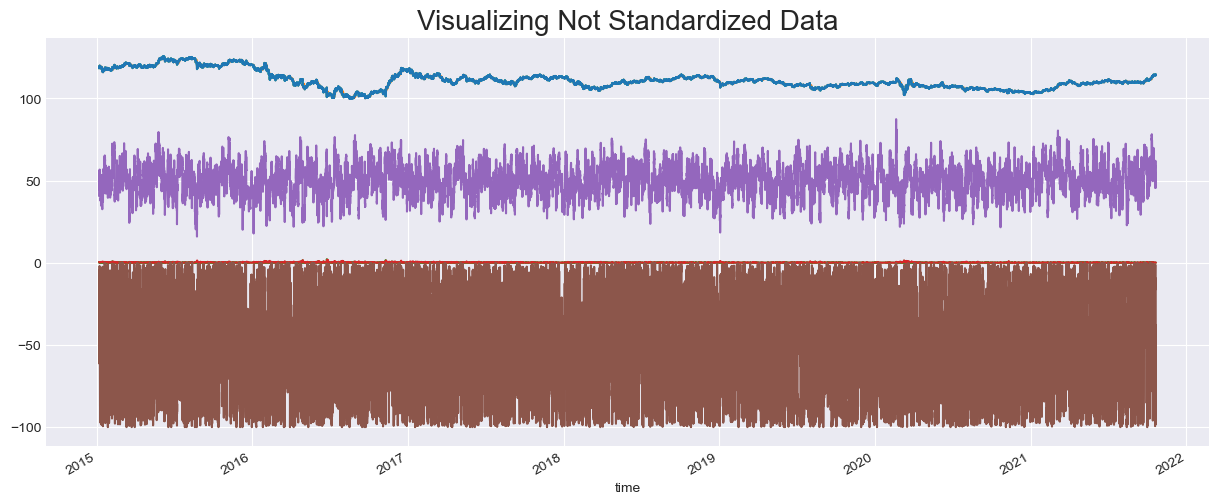

In [3003]:
# Plotting features before standardization to visualize their unequal scales
X_train.plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [3005]:
from sklearn.preprocessing import MinMaxScaler

In [3006]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

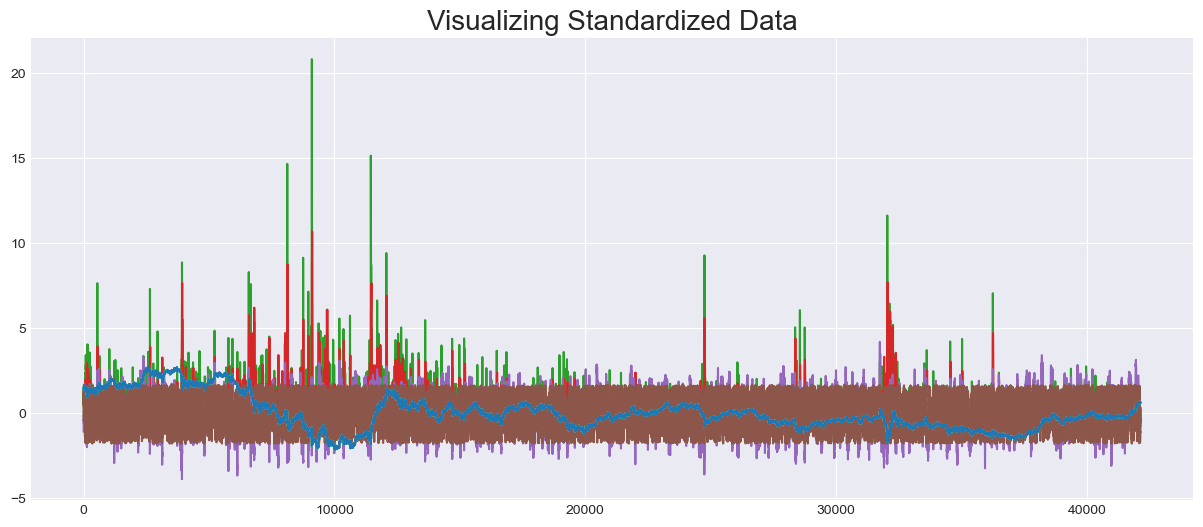

In [3007]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20)
plt.show()

**Transforming 2D data into 3D datasets**

This is the proper data shape received by the LSTM algorithm

In [3009]:
# Creating a function to transfor the 2D data into 3D data
def create_3d_data(X_data, y_data, lag):
    X_data_3d = []
    y_data_3d = []

    for i in range(lag, len(X_data)):
        X_data_3d.append(X_data[i-lag:i])
        y_data_3d.append(y_data[i])

    X_data_3d = np.array(X_data_3d)
    y_data_3d = np.array(y_data_3d)

    return X_data_3d, y_data_3d

**Transforming labels into classes**

- If percent change is lower than 0 is set to 0
- If equal 0 is set to 1
- If it's above 0 is set to 2

(those are price movement directions)

In [3180]:
X_train_3d, y_train_3d = create_3d_data(X_train_scaled, np.sign(y_train)+1, 5)
X_val_3d, y_val_3d = create_3d_data(X_val_scaled, np.sign(y_val)+1, 5)
X_test_3d, y_test_3d = create_3d_data(X_test_scaled, np.sign(y_test)+1, 5)


**Showing the 3 type of classes**

In [3300]:
pd.DataFrame(y_train_3d).value_counts()

0  
2.0    21088
0.0    20331
1.0      714
Name: count, dtype: int64

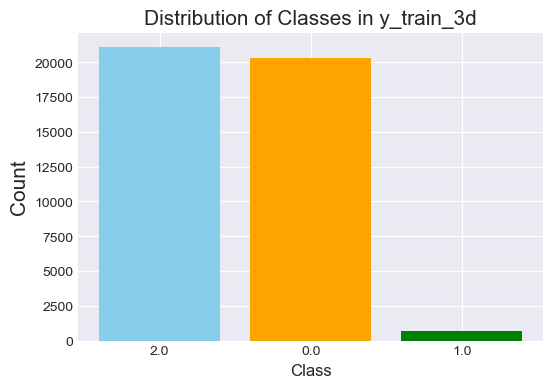

In [3302]:
value_counts = pd.DataFrame(y_train_3d).value_counts()

# Convert the result to a DataFrame for plotting
value_counts_df = value_counts.reset_index(name="count")

# Rename the columns for clarity
value_counts_df.columns = ["Class", "Count"]

# Plotting the bar chart
plt.figure(figsize=(6,4))
plt.bar(value_counts_df["Class"].astype(str), value_counts_df["Count"], color=["skyblue", "orange", "green"])

# Adding title and labels
plt.title("Distribution of Classes in y_train_3d", fontsize=15)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=15)
plt.show()


In [3052]:
# Showing the new shape of the X_train dataset
print(f"Old shape of X_train dataset    {X_train_scaled.shape}")
print(f"New shape of X_train dataset    {X_train_3d.shape}")

Old shape of X_train dataset    (42138, 11)
New shape of X_train dataset    (42133, 5, 11)


**Showing the first 3D row of the new X 3D dataset**

In [3055]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4,5,6,7,8,9,10
0,1.455350,1.635839,1.176432,1.358607,-1.094330,-0.443140,1.431949,1.388339,1.412917,1.437492,1.388203
1,1.452571,1.630084,0.706174,1.301059,-1.003755,-0.228916,1.443314,1.431904,1.388294,1.412870,1.437447
2,1.451434,1.624138,0.507389,1.182490,-0.867952,0.001786,1.460362,1.443269,1.431858,1.388247,1.412825
3,1.451939,1.619079,1.031412,1.088869,-0.493423,0.668260,1.509610,1.460316,1.443222,1.431810,1.388203
4,1.448781,1.613956,1.185580,0.941117,-0.410329,0.822061,1.520975,1.509563,1.460269,1.443174,1.431765


In [3057]:
# This are the new labels represented as classes
pd.DataFrame(y_test_3d).tail()

,0
9020,2.0
9021,2.0
9022,2.0
9023,2.0
9024,0.0


In [3308]:
# Showing original values
pd.DataFrame(y_test).tail()

,pct_change
time,
2024-09-13 19:00:00,0.001038
2024-09-13 20:00:00,0.000689
2024-09-13 21:00:00,0.000142
2024-09-13 22:00:00,0.000014
2024-09-13 23:00:00,-0.000341


**Prefetching data to make the algorithms run faster**

In [3062]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import os

In [3064]:
# Convert both X and y datasets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_3d, y_train_3d))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_3d, y_val_3d))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_3d, y_test_3d))

# Batch and prefetch
batch_size = 256  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [6297]:
# Creating a function to implement a ModelChechpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
    # Ensure the directory exists
    #os.makedirs(save_path, exist_ok=True)
    
    return ModelCheckpoint(
        filepath=os.path.join(save_path, f"{model_name}.keras"),
        monitor="val_loss",
        verbose=0,
        save_best_only=True
    )

**Creating a function to easily run several models and try different combination of hyperparameters**

In [5820]:
def run_lstm(train_sets, 
             val_sets, 
             model_name, 
             neurons=64, 
             hidden_layers=2, 
             p_epochs=30,
             dropout=0.20,
             lr=0.001, 
             early_stopping_ptn=15,
             reduce_plateau_ptn=5,
             rp_lr=0.05,
             path="model_experiments",
             p_batch_size=512):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break
    
   
    model = Sequential(name=model_name)

    # Input layer
    model.add(LSTM(neurons, input_shape=(features_input_shape), activation="tanh", return_sequences=True, name="input_layer_0"))

    # hidden layers
    for i in range(0, hidden_layers):
        model.add(LSTM(int(neurons/2), activation="tanh", return_sequences=True, name=f"hidden_layer_{i}"))
        model.add(Dropout(dropout, name=f"dropout_layer_{i}"))

    # Last hidden layer
    model.add(LSTM(int(neurons/4), activation="tanh", return_sequences=False, name=f"last_hidden_layer"))
    model.add(Dropout(dropout, name="last_dropout_layer_"))
    
    # Output layer
    model.add(Dense(3, activation="softmax", name="output_layer"))
    
    checkpoint_callback = create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets, 
                       batch_size=p_batch_size, 
                       epochs=p_epochs,
                       verbose=0,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau]
                      )
    return history

**Training the Model_1**

In [5871]:
history_model_1 = run_lstm(train_sets=train_dataset,
                           val_sets=val_dataset,
                           model_name="model_1",
                           neurons=7,
                           hidden_layers=1,
                           p_epochs=7,
                           lr=0.001,
                           early_stopping_ptn=5,
                           reduce_plateau_ptn=3,
                           path="model_experiments_1"
                          )


Epoch 1: val_loss improved from inf to 0.97577, saving model to model_experiments_1\model_1.keras

Epoch 2: val_loss improved from 0.97577 to 0.90323, saving model to model_experiments_1\model_1.keras

Epoch 3: val_loss improved from 0.90323 to 0.85071, saving model to model_experiments_1\model_1.keras

Epoch 4: val_loss improved from 0.85071 to 0.81183, saving model to model_experiments_1\model_1.keras

Epoch 5: val_loss improved from 0.81183 to 0.78034, saving model to model_experiments_1\model_1.keras

Epoch 6: val_loss improved from 0.78034 to 0.75883, saving model to model_experiments_1\model_1.keras

Epoch 7: val_loss improved from 0.75883 to 0.74884, saving model to model_experiments_1\model_1.keras


In [5872]:
from tensorflow.keras.models import load_model

**Loading the Model and Showing its Architecture**

In [5874]:
model_1 = load_model(f"model_experiments_1/{"model_1"}.keras")
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (LSTM)            │ (None, 5, 7)           │           532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (LSTM)           │ (None, 5, 3)           │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_0 (Dropout)       │ (None, 5, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden_layer (LSTM)        │ (None, 1)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dropout_layer_ (Dropout)   │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072 (8.10 KB)

 Trainable params: 690 (2.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,382 (5.40 KB)

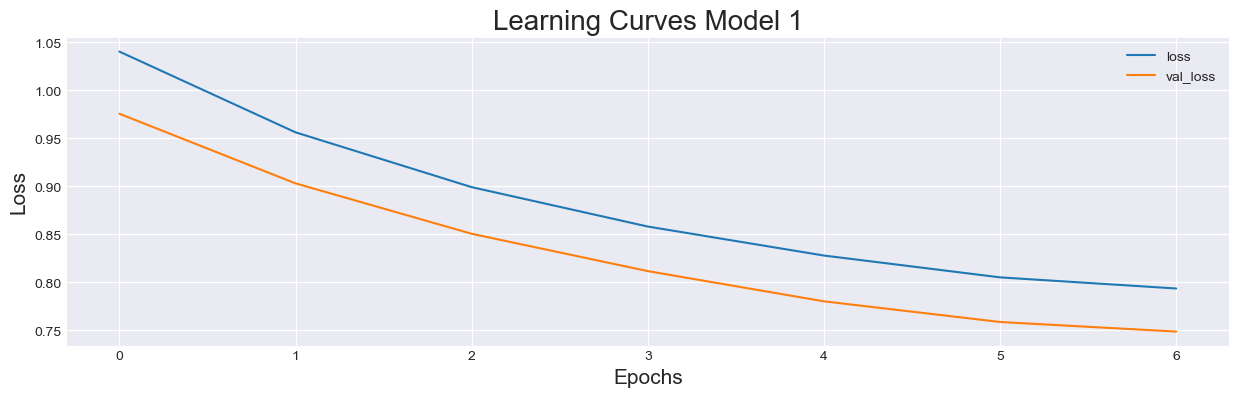

In [5875]:
pd.DataFrame(history_model_1.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model 1", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

**Note: I've run and tuned the hypeparameters several times and still LSTM algorithm not performing very well**

In [5877]:
# Evaluating the model
model_1.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4804 - loss: 0.7500


[0.7509186863899231, 0.4805540144443512]

**Making predictions**

In [5879]:
model_1_pred = model_1.predict(X_test_3d)

283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [5880]:
# Showing the shape of the predictions outcome
model_1_pred.shape

(9025, 3)

In [5881]:
# Showeing the predictions probabilites
pd.DataFrame(model_1_pred)

,0,1,2
0,0.482649,0.042414,0.474938
1,0.482927,0.042625,0.474447
2,0.483066,0.042732,0.474202
3,0.483179,0.042818,0.474003
4,0.483462,0.043036,0.473502
...,...,...,...
9020,0.484942,0.044203,0.470856
9021,0.484971,0.044226,0.470803
9022,0.484942,0.044203,0.470855
9023,0.484870,0.044145,0.470984


**Transforming predictions (probabilities) into positions**

In [5883]:
# Getting the predicted class index (e.g., 0, 1, or 2)
predicted_class_indices = np.argmax(model_1_pred, axis=1)
# Corrected mapping from model output indices to original labels
index_to_label = {0: -1, 1: 0, 2: 1}

# Predicted_class_indices is the output of np.argmax on model predictions
positions_model_1 = [index_to_label[idx] for idx in predicted_class_indices]
pd.DataFrame(positions_model_1).value_counts()

0 
-1    8943
 1      82
Name: count, dtype: int64

In [5884]:
predicted_labels_df = pd.DataFrame(positions_model_1, columns=["prediction"])
predicted_labels_df.head()

,prediction
0,-1
1,-1
2,-1
3,-1
4,-1


In [5885]:
# The original targets dataset has 9030 rows, since the lag used to make 3D data set is 5, it's required 
# to removed those firts 5 rows to match the amout of the predictions output for further analysis
pd.DataFrame(y_test)

,pct_change
time,
2023-04-03 19:00:00,0.000710
2023-04-03 20:00:00,0.000068
2023-04-03 21:00:00,-0.000785
2023-04-03 22:00:00,0.000672
2023-04-03 23:00:00,-0.000332
...,...
2024-09-13 19:00:00,0.001038
2024-09-13 20:00:00,0.000689
2024-09-13 21:00:00,0.000142


In [5886]:
# DataFrame comparing actual target values with predicted positions.
# The first 5 rows of y_test are excluded to match the length of predicted_labels_df, ensuring proper alignment for comparison.

# Checkout the docstring from for the "compute_stratety_returns" fucntions from backtest.py
returns_model_1 = backtest.compute_strategy_returns(y_test[5:], positions_model_1)
returns_model_1.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-04 00:00:00,0.000053,-1,1.0,-1,-0.000053
2023-04-04 01:00:00,-0.000446,-1,-1.0,-1,0.000446
2023-04-04 02:00:00,-0.000227,-1,-1.0,-1,0.000227
2023-04-04 03:00:00,0.001769,-1,1.0,-1,-0.001769
2023-04-04 04:00:00,0.001728,-1,1.0,-1,-0.001728


**Plotting the Cumulative Returns from Model 1**

Profits : -8.11%


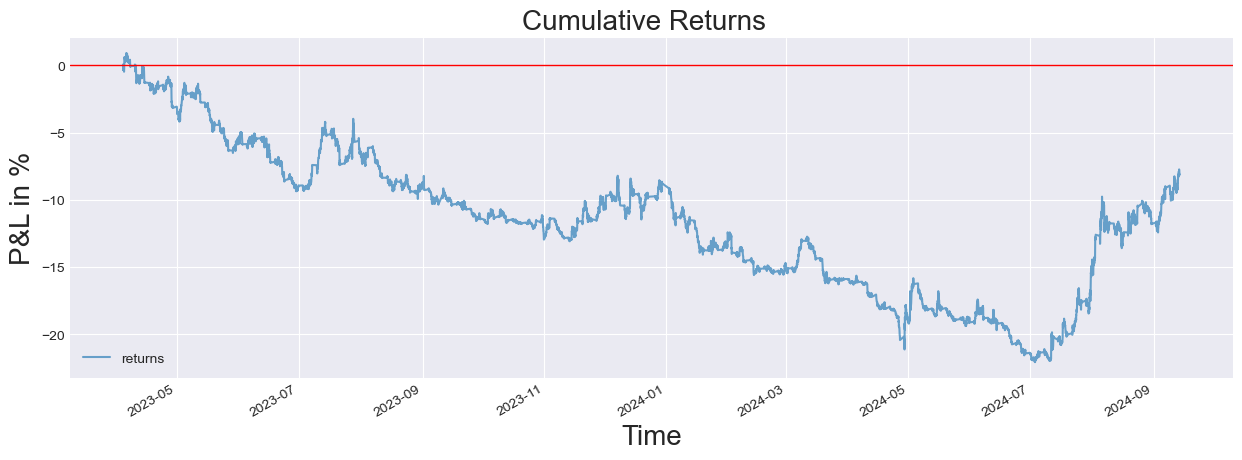

In [5888]:
# Checkout the docstring from for the "plot_test_returns" fucntions from display.py
display.plot_test_returns(returns_model_1["returns"])

**Forecast Accuracy Analysis for Model 1**

Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
0    4688
1    4337
Name: count, dtype: int64

Model has an accuracy of: 48.06%


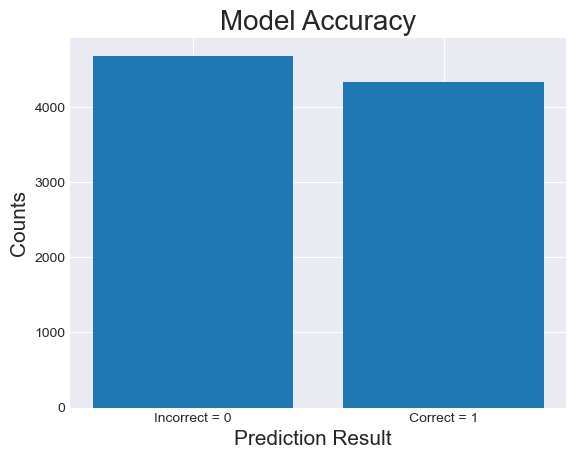

,real_position,pred_position,accuracy
time,,,
2023-04-04 00:00:00,1.0,-1,0
2023-04-04 01:00:00,-1.0,-1,1
2023-04-04 02:00:00,-1.0,-1,1
2023-04-04 03:00:00,1.0,-1,0
2023-04-04 04:00:00,1.0,-1,0


In [5890]:
# Checkout the docstring from for the "compute_model_accuracy" fucntions from backtest.py
backtest.compute_model_accuracy(returns_model_1["real_position"], returns_model_1["pred_position"])

**Confusion Matrix**

In [5892]:
from sklearn.metrics import confusion_matrix

**Confusion Matrix**

It shows us the performance of the model as follows:
- True positives
- True negatives
- False positives
- False negatives

In [6141]:
#The model has predicted almost exclusively downward price movements, indicating poor performance and a lack of balanced predictions.
confusion_matrix(returns_model_1["real_position"], returns_model_1["pred_position"])

array([[4296,    0,   41],
       [  45,    0,    0],
       [4602,    0,   41]], dtype=int64)

## New LSTM Model

**After some research the new model is enhanced for a more sophisticated: Regularization, Bidirectional Layers, and Batch Normalization are added**

- **Kernerl Regularizer:** This helps to prevent overfitting by keeping the weights from becoming too large.
- **Bidirectional layer:** With this the input data is processed both directions, from the beginning to the end and from the end to the beginning.
- **Batch normalization:** It helps stabilize the learning process by normalizing the inputs to each next layer in the network.

In [4088]:
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2

In [6330]:
def run_lstm(train_sets, 
             val_sets, 
             model_name, 
             neurons=64, 
             hidden_layers=2, 
             p_epochs=30,
             dropout=0.20,
             lr=0.001, 
             early_stopping_ptn=15,
             reduce_plateau_ptn=5,
             rp_lr=0.5,
             path="model_experiments",
             p_batch_size=512,
             kr_l2=0.1):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break
       
    model = Sequential(name=model_name)

    # Input layer
    model.add(Bidirectional(LSTM(neurons, activation="tanh", return_sequences=True, kernel_regularizer=l2(kr_l2)), 
                            input_shape=features_input_shape, name="input_layer_0"))
    model.add(BatchNormalization())

    # hidden layers
    for i in range(hidden_layers):
        model.add(Bidirectional(LSTM(int(neurons/2), activation="tanh", return_sequences=True, kernel_regularizer=l2(kr_l2)), name=f"hidden_layer_{i}"))
        model.add(BatchNormalization())
        model.add(Dropout(dropout, name=f"dropout_layer_{i}"))    

    # Last hidden layer
    model.add(Bidirectional(LSTM(int(neurons/4), activation="tanh", return_sequences=False, kernel_regularizer=l2(kr_l2)), name="last_hidden_layer"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout, name="Last_dropout_layer"))

    # Output layer
    model.add(Dense(3, activation="softmax", name="output_layer"))
    
    checkpoint_callback = create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2, min_lr=1e-4)

    # Compiling the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

    # Training the model
    history = model.fit(train_sets,
                        validation_data=val_sets,
                        batch_size=p_batch_size,
                        epochs=p_epochs,
                        verbose=0,
                        callbacks=[checkpoint_callback, early_stopping, reduce_plateau]
                        )
    return history

**Training the Model_2**

In [6271]:
history_model_2 = run_lstm(train_sets=train_dataset,
                           val_sets=val_dataset,
                           model_name="model_2",
                           neurons=5,
                           p_epochs=5,
                           hidden_layers=1,
                           lr=0.0005,
                           early_stopping_ptn=5,
                           reduce_plateau_ptn=3,
                           path="model_experiments_2",
                           kr_l2=0.2
                          )


Epoch 1: val_loss improved from inf to 7.66065, saving model to model_experiments_2\model_2.keras

Epoch 2: val_loss improved from 7.66065 to 5.05093, saving model to model_experiments_2\model_2.keras

Epoch 3: val_loss improved from 5.05093 to 3.43146, saving model to model_experiments_2\model_2.keras

Epoch 4: val_loss improved from 3.43146 to 2.40832, saving model to model_experiments_2\model_2.keras

Epoch 5: val_loss improved from 2.40832 to 1.72873, saving model to model_experiments_2\model_2.keras


**Loading the Model_2**

In [6273]:
model_2 = load_model(f"model_experiments_2/{"model_2"}.keras")
model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Bidirectional)   │ (None, 5, 10)          │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_388         │ (None, 5, 10)          │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (Bidirectional)  │ (None, 5, 4)           │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_389         │ (None, 5, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_0 (Dropout)       │ (None, 5, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden_layer               │ (None, 2)              │            48 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_390         │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Last_dropout_layer (Dropout)    │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,965 (11.59 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 1,956 (7.64 KB)

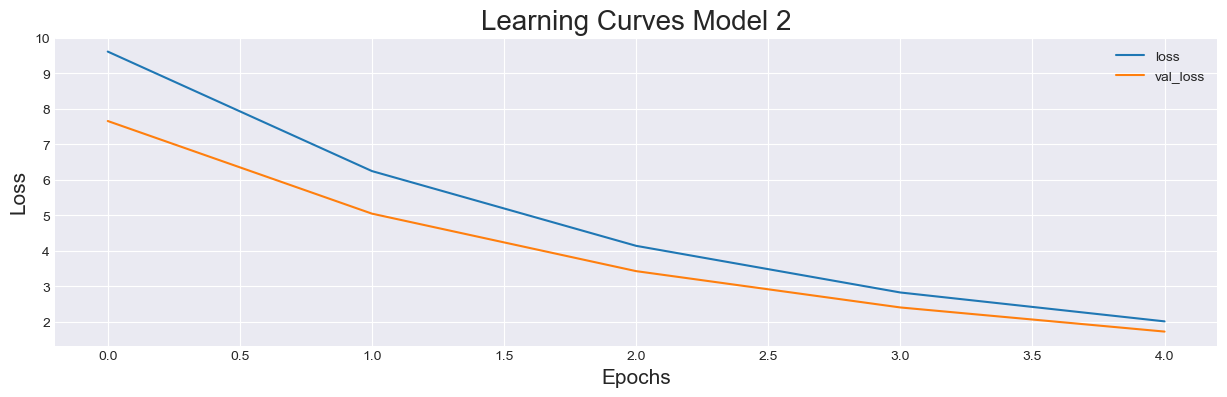

In [6274]:
pd.DataFrame(history_model_2.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model 2", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [6275]:
# Evaluating the model
model_2.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5087 - loss: 1.7502


[1.7579046487808228, 0.5021606683731079]

**Making Predictions from Model_2**

In [6277]:
model_2_pred = model_2.predict(X_test_3d)

283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [6278]:
# Showeing the predictions probabilites
pd.DataFrame(model_2_pred).head()

,0,1,2
0,0.406815,0.179102,0.414083
1,0.409020,0.170404,0.420576
2,0.410927,0.162301,0.426772
3,0.413086,0.152355,0.434559
4,0.415033,0.142337,0.442630


**Transforming predictions (probabilities) into positions fro Model_2**

In [6286]:
predicted_class_indices = np.argmax(model_2_pred, axis=1)
index_to_label = {0: -1, 1: 0, 2: 1}
positions_model_2 = [index_to_label[idx] for idx in predicted_class_indices]
positions_model_2
pd.DataFrame(positions_model_2).value_counts()

0 
 1    6572
-1    2453
Name: count, dtype: int64

**Computing Returns for Model_2**

In [6289]:
returns_model_2 = backtest.compute_strategy_returns(y_test[5:], positions_model_2)
returns_model_2.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-04 00:00:00,0.000053,1,1.0,1,0.000053
2023-04-04 01:00:00,-0.000446,1,-1.0,1,-0.000446
2023-04-04 02:00:00,-0.000227,1,-1.0,1,-0.000227
2023-04-04 03:00:00,0.001769,1,1.0,1,0.001769
2023-04-04 04:00:00,0.001728,1,1.0,1,0.001728


**Plotting the Cumulative Returns from Model 2**

Profits : 9.36%


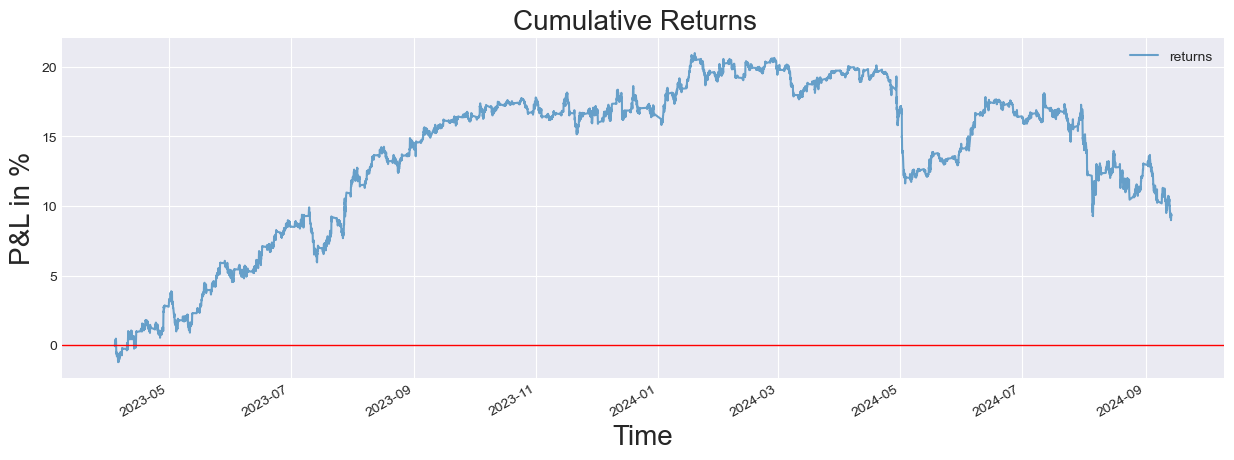

In [6292]:
display.plot_test_returns(returns_model_2["returns"])

**Confusion Matrix**

It shows us the performance of the model as follows:

In [6301]:
# We can see the model predicts in both directions upwards and downwards
confusion_matrix(returns_model_2["real_position"], returns_model_2["pred_position"])

array([[1162,    0, 3175],
       [  18,    0,   27],
       [1273,    0, 3370]], dtype=int64)

## Running 100 Versions

- This helps mitigate the effects of random weight initialization and stochastic training processes.
- With this, an ensemble model will be created using bagging, which improves generalization.

In [6311]:
from tqdm import tqdm

In [6329]:
models_history = []
for i in tqdm(range(100)):
    model_history = run_lstm(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name=f"model_{i}",
                             neurons=5,
                             p_epochs=5,
                             hidden_layers=1,
                             lr=0.0005,
                             early_stopping_ptn=5,
                             reduce_plateau_ptn=3,
                             path="model_experiments_2",
                             kr_l2=0.2)
    models_history.append(model_history)

100%|██████████| 100/100 [37:43<00:00, 22.64s/it]


**Plotting the learning curve for one of the models**

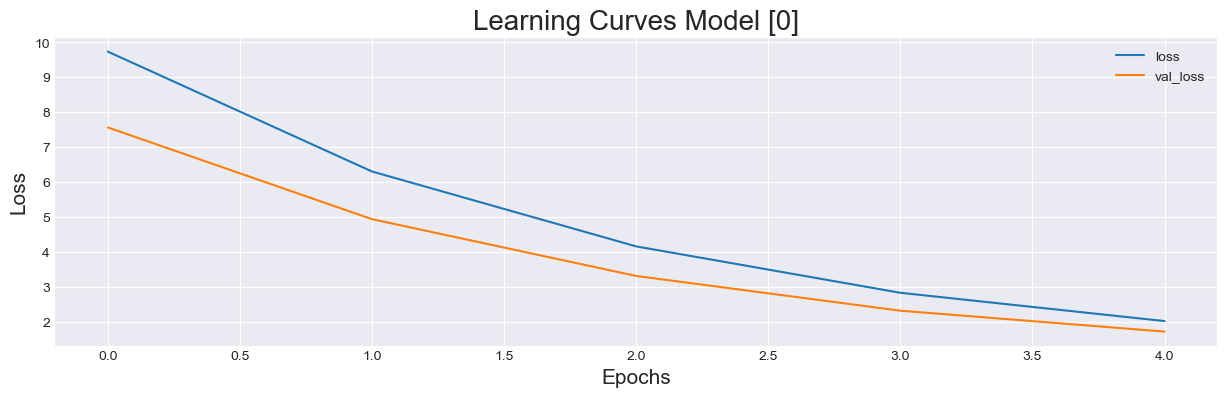

In [6347]:
pd.DataFrame(models_history[0].history)[["loss","val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model [0]", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

**Making Predictions on the 100 Models to Identify the Top 5 Best-performing**

In [6359]:
positions_df = pd.DataFrame()
returns_df = pd.DataFrame(y_test[5:], columns=["pct_change"])
index_to_label = {0: -1, 1: 0, 2: 1}

for i in tqdm(range(100)):
    model_name = f"model_{i}"
    model = load_model(f"model_experiments_2/{model_name}.keras")
    predictions = model.predict(X_test_3d)
    predicted_class_indices = np.argmax(predictions, axis=1)
    positions = [index_to_label[idx] for idx in predicted_class_indices]
    positions_df[f"position_test_{i}"] = positions
    returns_df[f"returns_test_{i}"] = positions * returns_df["pct_change"]

returns_df.drop("pct_change", axis=1, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


  1%|          | 1/100 [00:05<09:16,  5.62s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


  2%|▏         | 2/100 [00:11<09:22,  5.74s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


  3%|▎         | 3/100 [00:17<09:16,  5.74s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


  4%|▍         | 4/100 [00:22<09:03,  5.66s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


  5%|▌         | 5/100 [00:28<09:06,  5.75s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


  6%|▌         | 6/100 [00:34<08:58,  5.73s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


  7%|▋         | 7/100 [00:39<08:40,  5.60s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


  8%|▊         | 8/100 [00:45<08:32,  5.57s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


  9%|▉         | 9/100 [00:50<08:23,  5.54s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 10%|█         | 10/100 [00:55<08:13,  5.48s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 11%|█         | 11/100 [01:02<08:23,  5.66s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 12%|█▏        | 12/100 [01:07<08:12,  5.60s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 13%|█▎        | 13/100 [01:13<08:07,  5.60s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 14%|█▍        | 14/100 [01:18<07:53,  5.51s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 15%|█▌        | 15/100 [01:23<07:43,  5.45s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 16%|█▌        | 16/100 [01:28<07:32,  5.38s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 17%|█▋        | 17/100 [01:34<07:32,  5.45s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 18%|█▊        | 18/100 [01:40<07:42,  5.64s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


 19%|█▉        | 19/100 [01:47<07:58,  5.90s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 20%|██        | 20/100 [01:53<07:56,  5.95s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 21%|██        | 21/100 [01:58<07:43,  5.87s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 22%|██▏       | 22/100 [02:04<07:22,  5.67s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 23%|██▎       | 23/100 [02:09<07:03,  5.50s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 24%|██▍       | 24/100 [02:14<06:51,  5.41s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 25%|██▌       | 25/100 [02:19<06:41,  5.35s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 26%|██▌       | 26/100 [02:25<06:49,  5.53s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 27%|██▋       | 27/100 [02:30<06:33,  5.39s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 28%|██▊       | 28/100 [02:35<06:21,  5.30s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 29%|██▉       | 29/100 [02:41<06:18,  5.33s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 30%|███       | 30/100 [02:46<06:09,  5.28s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 31%|███       | 31/100 [02:51<06:04,  5.28s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 32%|███▏      | 32/100 [02:56<05:57,  5.26s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 33%|███▎      | 33/100 [03:02<05:56,  5.32s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


 34%|███▍      | 34/100 [03:08<06:01,  5.48s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 35%|███▌      | 35/100 [03:13<06:00,  5.54s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 36%|███▌      | 36/100 [03:19<05:59,  5.61s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 37%|███▋      | 37/100 [03:25<05:50,  5.57s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 38%|███▊      | 38/100 [03:30<05:37,  5.44s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


 39%|███▉      | 39/100 [03:35<05:26,  5.34s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 40%|████      | 40/100 [03:41<05:27,  5.47s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 41%|████      | 41/100 [03:47<05:35,  5.68s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 42%|████▏     | 42/100 [03:53<05:33,  5.75s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


 43%|████▎     | 43/100 [03:58<05:20,  5.63s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 44%|████▍     | 44/100 [04:03<05:10,  5.54s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 45%|████▌     | 45/100 [04:09<05:05,  5.56s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 46%|████▌     | 46/100 [04:15<05:02,  5.60s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


 47%|████▋     | 47/100 [04:20<04:51,  5.50s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 48%|████▊     | 48/100 [04:25<04:38,  5.35s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 49%|████▉     | 49/100 [04:30<04:34,  5.39s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 50%|█████     | 50/100 [04:36<04:36,  5.52s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 51%|█████     | 51/100 [04:42<04:30,  5.53s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 52%|█████▏    | 52/100 [04:47<04:20,  5.42s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 53%|█████▎    | 53/100 [04:53<04:20,  5.55s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 54%|█████▍    | 54/100 [04:58<04:08,  5.41s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


 55%|█████▌    | 55/100 [05:03<04:03,  5.41s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 56%|█████▌    | 56/100 [05:08<03:54,  5.33s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 57%|█████▋    | 57/100 [05:13<03:45,  5.23s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 58%|█████▊    | 58/100 [05:18<03:38,  5.19s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 59%|█████▉    | 59/100 [05:23<03:29,  5.11s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 60%|██████    | 60/100 [05:28<03:23,  5.08s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 61%|██████    | 61/100 [05:33<03:16,  5.03s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 62%|██████▏   | 62/100 [05:38<03:09,  4.99s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 63%|██████▎   | 63/100 [05:43<03:03,  4.95s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 64%|██████▍   | 64/100 [05:48<02:57,  4.93s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 65%|██████▌   | 65/100 [05:53<02:54,  4.98s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 66%|██████▌   | 66/100 [05:58<02:53,  5.09s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 67%|██████▋   | 67/100 [06:03<02:47,  5.09s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 68%|██████▊   | 68/100 [06:08<02:39,  4.99s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 69%|██████▉   | 69/100 [06:13<02:34,  4.97s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 70%|███████   | 70/100 [06:18<02:28,  4.96s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 71%|███████   | 71/100 [06:23<02:23,  4.96s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 72%|███████▏  | 72/100 [06:28<02:17,  4.93s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 73%|███████▎  | 73/100 [06:33<02:14,  4.99s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 74%|███████▍  | 74/100 [06:38<02:08,  4.95s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 75%|███████▌  | 75/100 [06:43<02:06,  5.06s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 76%|███████▌  | 76/100 [06:48<02:00,  5.04s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 77%|███████▋  | 77/100 [06:53<01:55,  5.03s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 78%|███████▊  | 78/100 [06:58<01:50,  5.04s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 79%|███████▉  | 79/100 [07:03<01:46,  5.08s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 80%|████████  | 80/100 [07:09<01:41,  5.07s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 81%|████████  | 81/100 [07:13<01:35,  5.04s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 82%|████████▏ | 82/100 [07:19<01:32,  5.11s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 83%|████████▎ | 83/100 [07:24<01:26,  5.06s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 84%|████████▍ | 84/100 [07:29<01:22,  5.17s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 85%|████████▌ | 85/100 [07:34<01:18,  5.20s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 86%|████████▌ | 86/100 [07:39<01:11,  5.10s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 87%|████████▋ | 87/100 [07:44<01:05,  5.03s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 88%|████████▊ | 88/100 [07:49<01:00,  5.06s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 89%|████████▉ | 89/100 [07:54<00:55,  5.01s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 90%|█████████ | 90/100 [07:59<00:50,  5.02s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 91%|█████████ | 91/100 [08:04<00:45,  5.02s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


 92%|█████████▏| 92/100 [08:10<00:42,  5.28s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 93%|█████████▎| 93/100 [08:15<00:36,  5.22s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 94%|█████████▍| 94/100 [08:20<00:30,  5.15s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


 95%|█████████▌| 95/100 [08:26<00:26,  5.21s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


 96%|█████████▌| 96/100 [08:31<00:20,  5.21s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 97%|█████████▋| 97/100 [08:36<00:15,  5.13s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 98%|█████████▊| 98/100 [08:40<00:10,  5.03s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


 99%|█████████▉| 99/100 [08:45<00:05,  5.03s/it]

283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


100%|██████████| 100/100 [08:50<00:00,  5.31s/it]


**DataFrame with all Predictions Converted to Positions (directions)**

In [6364]:
positions_df.head()

,position_test_0,position_test_1,position_test_2,position_test_3,position_test_4,position_test_5,position_test_6,position_test_7,position_test_8,position_test_9,...,position_test_90,position_test_91,position_test_92,position_test_93,position_test_94,position_test_95,position_test_96,position_test_97,position_test_98,position_test_99
0,-1,-1,-1,1,-1,-1,-1,-1,0,-1,...,-1,1,-1,-1,1,-1,-1,1,-1,-1
1,-1,-1,-1,1,-1,-1,-1,-1,0,-1,...,-1,1,-1,-1,1,-1,-1,1,-1,-1
2,-1,-1,-1,1,-1,-1,-1,-1,0,-1,...,-1,1,-1,-1,1,-1,-1,1,-1,-1
3,-1,-1,-1,1,-1,-1,-1,-1,0,-1,...,-1,1,-1,-1,1,-1,-1,-1,-1,-1
4,-1,-1,-1,1,-1,-1,-1,-1,0,-1,...,-1,1,-1,-1,1,-1,-1,-1,-1,-1


**DataFrame with Returns from all Model Predictions**

In [6388]:
returns_df.head()

,returns_test_0,returns_test_1,returns_test_2,returns_test_3,returns_test_4,returns_test_5,returns_test_6,returns_test_7,returns_test_8,returns_test_9,...,returns_test_90,returns_test_91,returns_test_92,returns_test_93,returns_test_94,returns_test_95,returns_test_96,returns_test_97,returns_test_98,returns_test_99
time,,,,,,,,,,,,,,,,,,,,,
2023-04-04 00:00:00,-0.000053,-0.000053,-0.000053,0.000053,-0.000053,-0.000053,-0.000053,-0.000053,0.0,-0.000053,...,-0.000053,0.000053,-0.000053,-0.000053,0.000053,-0.000053,-0.000053,0.000053,-0.000053,-0.000053
2023-04-04 01:00:00,0.000446,0.000446,0.000446,-0.000446,0.000446,0.000446,0.000446,0.000446,-0.0,0.000446,...,0.000446,-0.000446,0.000446,0.000446,-0.000446,0.000446,0.000446,-0.000446,0.000446,0.000446
2023-04-04 02:00:00,0.000227,0.000227,0.000227,-0.000227,0.000227,0.000227,0.000227,0.000227,-0.0,0.000227,...,0.000227,-0.000227,0.000227,0.000227,-0.000227,0.000227,0.000227,-0.000227,0.000227,0.000227
2023-04-04 03:00:00,-0.001769,-0.001769,-0.001769,0.001769,-0.001769,-0.001769,-0.001769,-0.001769,0.0,-0.001769,...,-0.001769,0.001769,-0.001769,-0.001769,0.001769,-0.001769,-0.001769,-0.001769,-0.001769,-0.001769
2023-04-04 04:00:00,-0.001728,-0.001728,-0.001728,0.001728,-0.001728,-0.001728,-0.001728,-0.001728,0.0,-0.001728,...,-0.001728,0.001728,-0.001728,-0.001728,0.001728,-0.001728,-0.001728,-0.001728,-0.001728,-0.001728


**Plotting the Backtest Returns for all 100 Models**

Profits : -415.62%


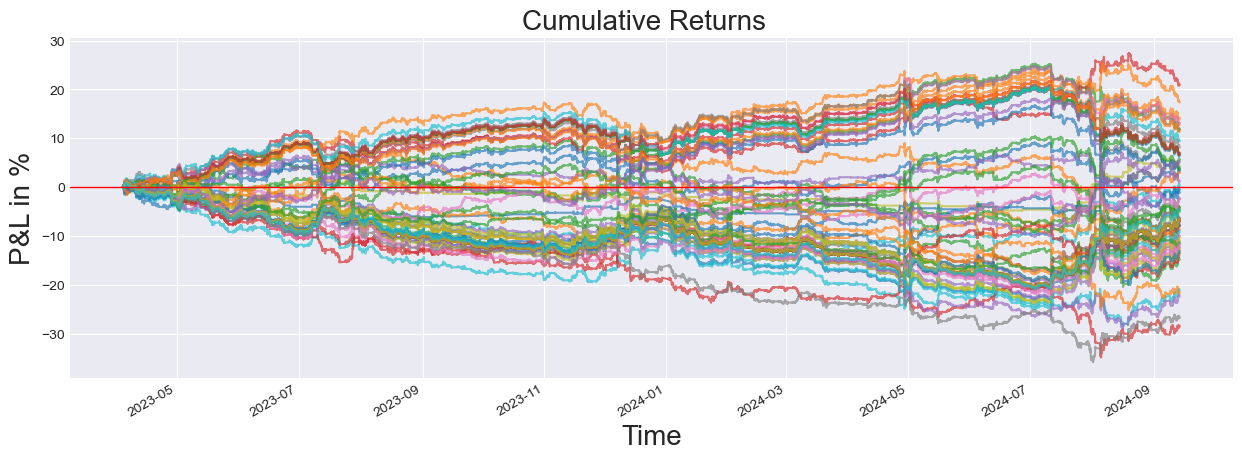

In [6432]:
display.plot_test_returns(returns_df, False)

## Analysis to find out what are the 5 best well rounded performing model

**Here, the returns are split into two separate sets: one for testing and the other for validation.**

The idea is to find the 5 models that perform the best on the test set, and then evaluate whether they continue to perform well on the second half (the validation set). If they do, this indicates good generalization.

In [6385]:
# Splitting the returns into test and validation sets to evaluate generalization
test_split = int(0.50 * len(returns_df))

test_returns = returns_df.iloc[:test_split]
val_returns = returns_df.iloc[test_split:]

**Dataframe with key performing results**

In [6558]:
# Check out the docstrings for the "compute_drawdown" function in the backtest.py file
values = pd.DataFrame(index=["returns", "drawdown", "returns/drawdown"])

for column in test_returns.columns:
    returns_on_test, drawdown_on_test = test_returns[column].cumsum().iloc[-1], -np.min(backtest.compute_drawdown(test_returns[column]))
    values[column] = returns_on_test, drawdown_on_test, returns_on_test/drawdown_on_test

In [6560]:
values.transpose().sort_values(by="returns/drawdown", ascending=False).head()

,returns,drawdown,returns/drawdown
returns_test_57,0.104656,0.049603,2.109878
returns_test_31,0.099090,0.048611,2.038405
returns_test_21,0.102492,0.051211,2.001380
returns_test_11,0.112147,0.061177,1.833150
returns_test_73,0.086626,0.057280,1.512321


**Plotting the returns from the Top 5 best performing model based on "returns/drawdown" metric on the "test_returns" dataset**

Profits : 50.50%


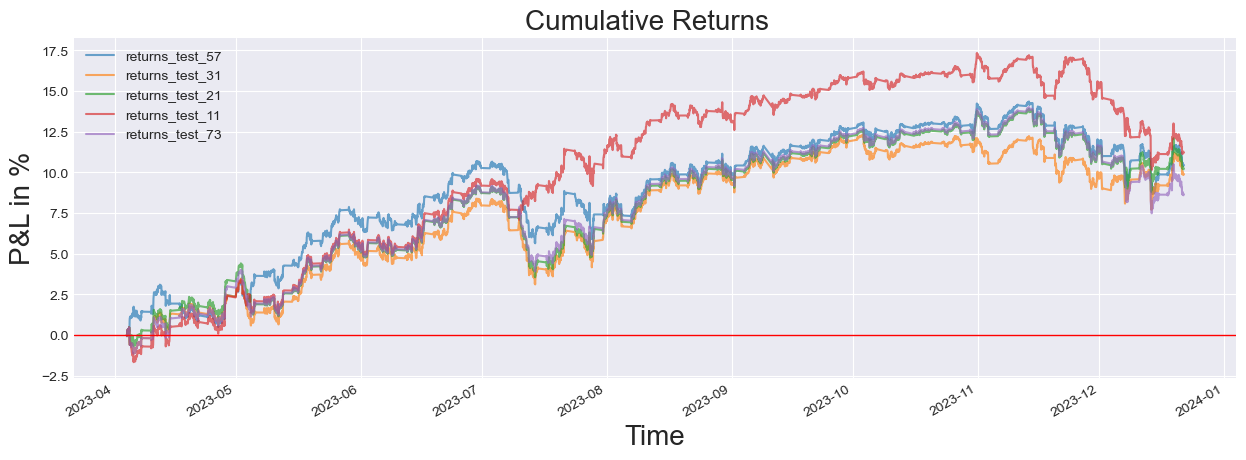

In [6424]:
display.plot_test_returns(test_returns[["returns_test_57","returns_test_31","returns_test_21","returns_test_11","returns_test_73"]])

**Plotting the returns from the Top 5 best performing model based on "returns/drawdown" metric on the "val_returns" dataset**

This will show if the models that perform well on the test sets will continue to perform well on new unseen data (validation dataset)

Profits : 13.05%


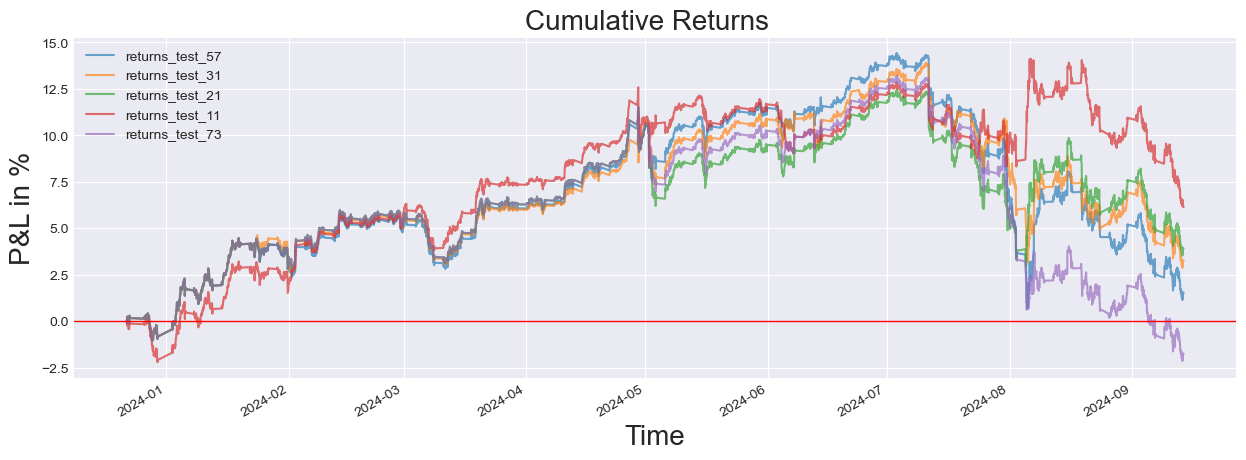

In [6405]:
display.plot_test_returns(val_returns[["returns_test_57","returns_test_31","returns_test_21","returns_test_11","returns_test_73"]])

**The best performing model on both Test and Validation datasets based on returns/drawdown metric is the model 11**

Plotting the returns obtained with **Molel_11**

Profits : 17.38%


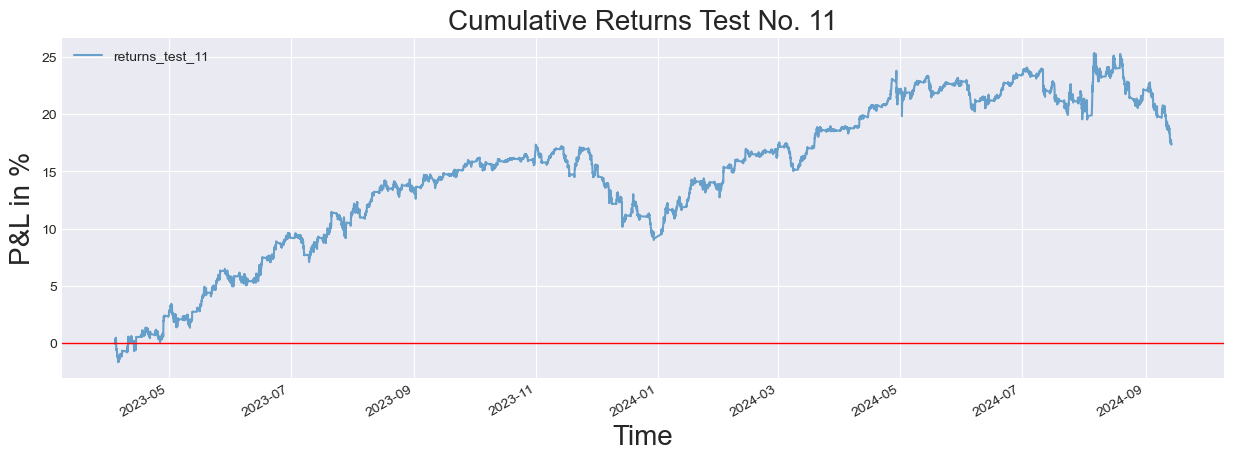

In [6516]:
display.plot_test_returns(returns_df["returns_test_11"], name="Test No. 11")

**Forecast Accuracy Analysis for Model_11**

**Metric:** returns/drawdown
- Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    4624
0    4401
Name: count, dtype: int64

Model has an accuracy of: 51.24%


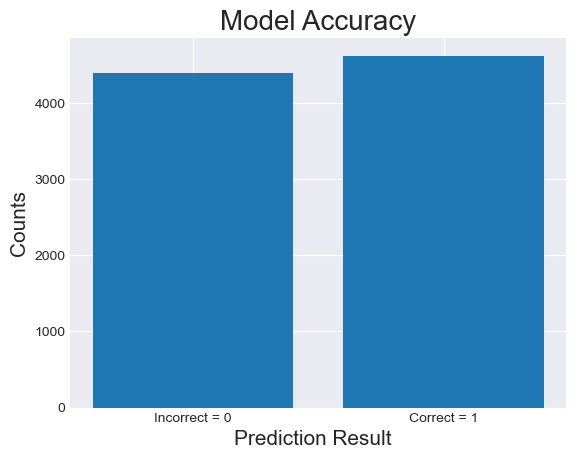

,real_position,pred_position,accuracy
0,1.0,1,1
1,-1.0,1,0
2,-1.0,1,0
3,1.0,1,1
4,1.0,1,1


In [6496]:
backtest.compute_model_accuracy(np.sign(y_test[5:].values), positions_df["position_test_11"])

**Confusion Matrix**

In [6504]:
confusion_matrix(np.sign(y_test[5:].values), positions_df["position_test_11"])

array([[ 359,    0, 3978],
       [   3,    0,   42],
       [ 378,    0, 4265]], dtype=int64)

## Analysis of the best performing models using TensorFlow's evaluation method

In [6521]:
evaluation_df = pd.DataFrame(columns=["Loss", "Accuracy"])

# Loop through 100 models, evaluate each, and store the results
for i in tqdm(range(100)):
    model_name = f"model_{i}"
    model = load_model(f"model_experiments_2/{model_name}.keras")
    evaluation = model.evaluate(test_dataset)
    evaluation_df.loc[model_name] = evaluation

  0%|          | 0/100 [00:00<?, ?it/s]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4773 - loss: 1.7259


  1%|          | 1/100 [00:03<06:29,  3.94s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4929 - loss: 1.7495


  2%|▏         | 2/100 [00:07<06:15,  3.83s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5179 - loss: 1.7549


  3%|▎         | 3/100 [00:11<06:22,  3.95s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5138 - loss: 1.7655


  4%|▍         | 4/100 [00:15<06:17,  3.93s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4805 - loss: 1.5130


  5%|▌         | 5/100 [00:19<06:11,  3.91s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4805 - loss: 1.7648


  6%|▌         | 6/100 [00:24<06:28,  4.14s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.6507


  7%|▋         | 7/100 [00:28<06:46,  4.37s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.7265


  8%|▊         | 8/100 [00:33<06:52,  4.48s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1071 - loss: 2.1719


  9%|▉         | 9/100 [00:38<06:46,  4.47s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.7965


 10%|█         | 10/100 [00:42<06:43,  4.49s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.8825


 11%|█         | 11/100 [00:46<06:33,  4.42s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5135 - loss: 1.8634


 12%|█▏        | 12/100 [00:51<06:19,  4.32s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.8451


 13%|█▎        | 13/100 [00:55<06:20,  4.37s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5045 - loss: 1.7362


 14%|█▍        | 14/100 [00:59<06:15,  4.37s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4805 - loss: 2.1971


 15%|█▌        | 15/100 [01:04<06:11,  4.37s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4805 - loss: 1.6253


 16%|█▌        | 16/100 [01:08<06:07,  4.38s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5000 - loss: 1.7225


 17%|█▋        | 17/100 [01:12<05:53,  4.26s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5148 - loss: 1.7062


 18%|█▊        | 18/100 [01:16<05:39,  4.15s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.8290


 19%|█▉        | 19/100 [01:20<05:31,  4.09s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4805 - loss: 1.9107


 20%|██        | 20/100 [01:24<05:23,  4.05s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5148 - loss: 1.5949


 21%|██        | 21/100 [01:28<05:20,  4.06s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5147 - loss: 1.5968


 22%|██▏       | 22/100 [01:32<05:13,  4.02s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4821 - loss: 1.6077


 23%|██▎       | 23/100 [01:36<05:13,  4.07s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.8307


 24%|██▍       | 24/100 [01:41<05:22,  4.25s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4805 - loss: 2.0767


 25%|██▌       | 25/100 [01:45<05:22,  4.30s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4799 - loss: 1.8792


 26%|██▌       | 26/100 [01:49<05:16,  4.28s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4805 - loss: 1.6797


 27%|██▋       | 27/100 [01:53<05:07,  4.21s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5139 - loss: 1.5662


 28%|██▊       | 28/100 [01:58<05:05,  4.25s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4816 - loss: 1.6534


 29%|██▉       | 29/100 [02:02<05:02,  4.27s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4887 - loss: 1.8802


 30%|███       | 30/100 [02:06<04:51,  4.16s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1802 - loss: 2.1275


 31%|███       | 31/100 [02:10<04:50,  4.20s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5179 - loss: 1.8836


 32%|███▏      | 32/100 [02:14<04:36,  4.06s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4805 - loss: 1.7126


 33%|███▎      | 33/100 [02:18<04:29,  4.02s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.8092


 34%|███▍      | 34/100 [02:22<04:23,  4.00s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4805 - loss: 1.6986


 35%|███▌      | 35/100 [02:26<04:15,  3.93s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 1.7238


 36%|███▌      | 36/100 [02:30<04:10,  3.92s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5147 - loss: 1.8033


 37%|███▋      | 37/100 [02:33<04:03,  3.87s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4805 - loss: 1.6111


 38%|███▊      | 38/100 [02:37<03:58,  3.85s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5148 - loss: 1.7890


 39%|███▉      | 39/100 [02:41<04:02,  3.98s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5148 - loss: 1.6729


 40%|████      | 40/100 [02:46<04:06,  4.10s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4934 - loss: 1.7579


 41%|████      | 41/100 [02:50<03:59,  4.07s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4915 - loss: 1.8871


 42%|████▏     | 42/100 [02:54<04:00,  4.15s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4917 - loss: 1.8281


 43%|████▎     | 43/100 [02:59<04:01,  4.24s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 2.2780


 44%|████▍     | 44/100 [03:03<04:05,  4.38s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4579 - loss: 1.9896


 45%|████▌     | 45/100 [03:08<04:06,  4.48s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4808 - loss: 1.9294


 46%|████▌     | 46/100 [03:12<03:54,  4.35s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 2.0459


 47%|████▋     | 47/100 [03:17<03:52,  4.39s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5145 - loss: 1.6996


 48%|████▊     | 48/100 [03:20<03:40,  4.24s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4805 - loss: 1.8105


 49%|████▉     | 49/100 [03:24<03:29,  4.12s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4805 - loss: 1.6097


 50%|█████     | 50/100 [03:28<03:24,  4.10s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4913 - loss: 1.8298


 51%|█████     | 51/100 [03:33<03:23,  4.15s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4805 - loss: 1.6782


 52%|█████▏    | 52/100 [03:37<03:19,  4.17s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5148 - loss: 1.7090


 53%|█████▎    | 53/100 [03:41<03:13,  4.11s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4805 - loss: 2.0815


 54%|█████▍    | 54/100 [03:45<03:09,  4.12s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4301 - loss: 1.7559


 55%|█████▌    | 55/100 [03:49<03:08,  4.19s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4808 - loss: 2.0444


 56%|█████▌    | 56/100 [03:53<03:02,  4.14s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4805 - loss: 2.3774


 57%|█████▋    | 57/100 [03:57<02:54,  4.05s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5014 - loss: 1.8999


 58%|█████▊    | 58/100 [04:01<02:46,  3.96s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4803 - loss: 1.8154


 59%|█████▉    | 59/100 [04:05<02:38,  3.87s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 13ms/step - accuracy: 0.4773 - loss: 1.7883


 60%|██████    | 60/100 [05:46<22:06, 33.16s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4805 - loss: 1.7559


 61%|██████    | 61/100 [05:50<15:50, 24.38s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5024 - loss: 1.7205


 62%|██████▏   | 62/100 [05:54<11:34, 18.27s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5000 - loss: 1.9380


 63%|██████▎   | 63/100 [05:58<08:39, 14.04s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4858 - loss: 1.7331


 64%|██████▍   | 64/100 [06:02<06:36, 11.01s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4789 - loss: 1.8685


 65%|██████▌   | 65/100 [06:06<05:12,  8.92s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4805 - loss: 1.7587


 66%|██████▌   | 66/100 [06:10<04:11,  7.39s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4805 - loss: 1.7529


 67%|██████▋   | 67/100 [06:14<03:29,  6.36s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4805 - loss: 1.9259


 68%|██████▊   | 68/100 [06:18<03:01,  5.66s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4808 - loss: 1.6297


 69%|██████▉   | 69/100 [06:22<02:39,  5.15s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5163 - loss: 1.8821


 70%|███████   | 70/100 [06:26<02:25,  4.84s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5111 - loss: 1.7765


 71%|███████   | 71/100 [06:30<02:15,  4.68s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4805 - loss: 1.7973


 72%|███████▏  | 72/100 [06:35<02:08,  4.58s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5043 - loss: 1.8717


 73%|███████▎  | 73/100 [06:39<01:58,  4.39s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5153 - loss: 1.7784


 74%|███████▍  | 74/100 [06:43<01:50,  4.26s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5136 - loss: 1.9151


 75%|███████▌  | 75/100 [06:46<01:42,  4.12s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4805 - loss: 1.7310


 76%|███████▌  | 76/100 [06:50<01:37,  4.04s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4805 - loss: 1.7561


 77%|███████▋  | 77/100 [06:54<01:32,  4.03s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4821 - loss: 1.9857


 78%|███████▊  | 78/100 [06:58<01:26,  3.94s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4821 - loss: 1.7896


 79%|███████▉  | 79/100 [07:02<01:23,  3.97s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4805 - loss: 1.7149


 80%|████████  | 80/100 [07:06<01:18,  3.94s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4805 - loss: 2.5331


 81%|████████  | 81/100 [07:10<01:13,  3.87s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5141 - loss: 1.7221


 82%|████████▏ | 82/100 [07:14<01:11,  3.95s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1895 - loss: 2.7252


 83%|████████▎ | 83/100 [07:18<01:06,  3.93s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4918 - loss: 1.8961


 84%|████████▍ | 84/100 [07:22<01:02,  3.93s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4810 - loss: 1.8994


 85%|████████▌ | 85/100 [07:25<00:58,  3.91s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4805 - loss: 2.0045


 86%|████████▌ | 86/100 [07:29<00:54,  3.91s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5007 - loss: 1.9654


 87%|████████▋ | 87/100 [07:33<00:51,  3.98s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4805 - loss: 1.7898


 88%|████████▊ | 88/100 [07:37<00:46,  3.88s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4830 - loss: 2.3335 


 89%|████████▉ | 89/100 [07:41<00:42,  3.82s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4795 - loss: 1.7618


 90%|█████████ | 90/100 [07:45<00:38,  3.83s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4843 - loss: 1.6808


 91%|█████████ | 91/100 [07:48<00:34,  3.81s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5021 - loss: 1.7585


 92%|█████████▏| 92/100 [07:52<00:30,  3.77s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3480 - loss: 3.3630


 93%|█████████▎| 93/100 [07:56<00:26,  3.78s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4812 - loss: 1.8010


 94%|█████████▍| 94/100 [08:00<00:22,  3.80s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4931 - loss: 1.7612


 95%|█████████▌| 95/100 [08:04<00:19,  3.84s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4805 - loss: 1.5771


 96%|█████████▌| 96/100 [08:08<00:15,  3.86s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4834 - loss: 1.9084


 97%|█████████▋| 97/100 [08:11<00:11,  3.83s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4826 - loss: 1.9636


 98%|█████████▊| 98/100 [08:15<00:07,  3.83s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4805 - loss: 1.8215


 99%|█████████▉| 99/100 [08:19<00:03,  3.79s/it]

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4810 - loss: 1.6321


100%|██████████| 100/100 [08:23<00:00,  5.03s/it]


In [6536]:
evaluation_df.sort_values(by="Loss").head()

,Loss,Accuracy
model_4,1.512435,0.480554
model_27,1.566464,0.513795
model_95,1.574402,0.480554
model_20,1.580558,0.514349
model_21,1.594823,0.515235


**Plotting the returns from the Top 5 best performing model based on "Loss" metric on the "test_returns" dataset**

Profits : 7.53%


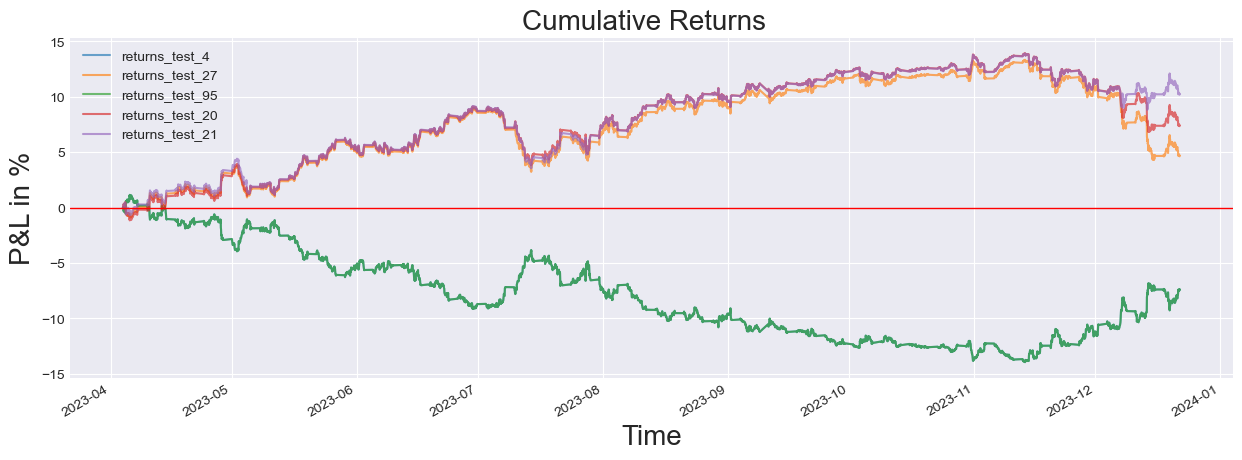

In [6538]:
display.plot_test_returns(test_returns[["returns_test_4","returns_test_27","returns_test_95","returns_test_20","returns_test_21"]])

**Plotting the returns from the Top 5 best performing model based on "Loss" metric on the "val_returns" dataset**

This will show if the modesl that perform well on the test sets will also perform well on new unseen data (validation dataset)

Profits : 7.58%


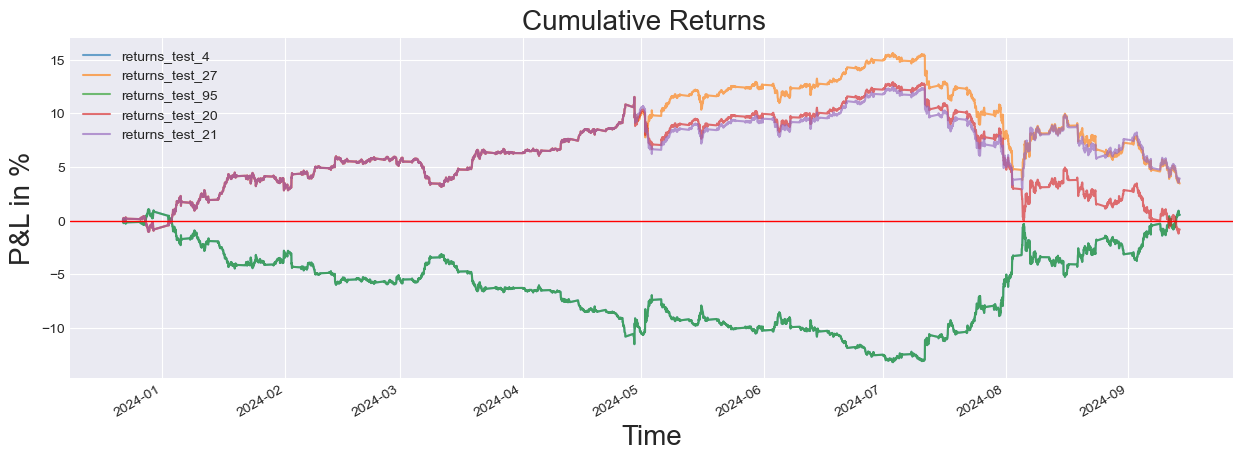

In [6543]:
display.plot_test_returns(val_returns[["returns_test_4","returns_test_27","returns_test_95","returns_test_20","returns_test_21"]])

**The best performing model on both test and validation datasets based on Loss metric is the model 21**

Plotting the returns obtained with model 21

Profits : 14.15%


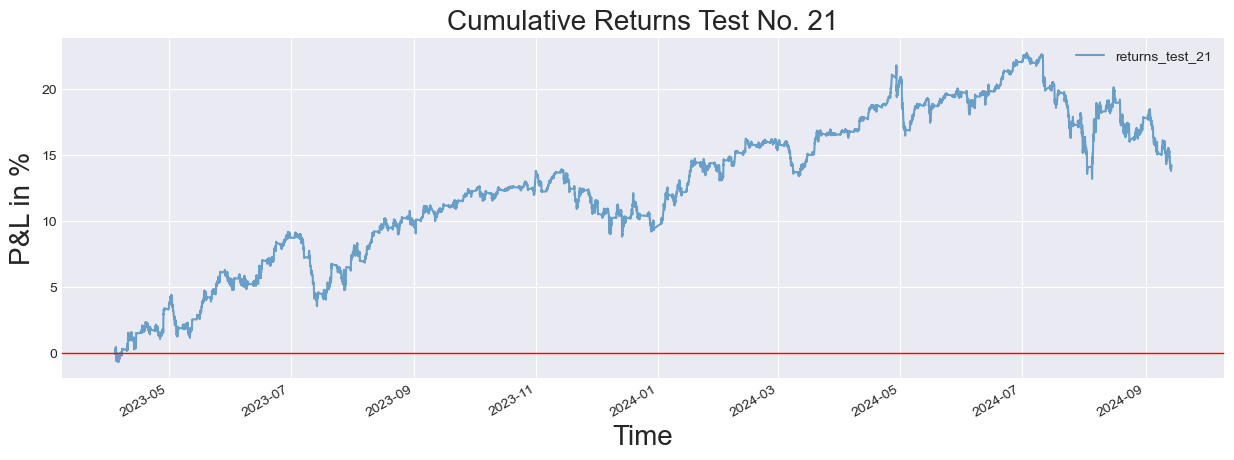

In [6632]:
display.plot_test_returns(returns_df["returns_test_21"], name="Test No. 21")

## Analysis of the whole "returns_df" dataset

**Finding the best performing model that through best returns throughout the entire original test dataset**

Here is used the whole "returns_df" dataframe rather than using only "test_returns" or "val_returns"

In [6572]:
# Check out the docstrings for the "compute_drawdown" function in the backtest.py file
values = pd.DataFrame(index=["returns", "drawdown", "returns/drawdown"])

for column in test_returns.columns:
    returns_on_test, drawdown_on_test = returns_df[column].cumsum().iloc[-1], -np.min(backtest.compute_drawdown(returns_df[column]))
    values[column] = returns_on_test, drawdown_on_test, returns_on_test/drawdown_on_test

In [6574]:
values.transpose().sort_values(by="returns/drawdown", ascending=False).head()

,returns,drawdown,returns/drawdown
returns_test_3,0.208937,0.077006,2.713240
returns_test_11,0.173838,0.071017,2.447853
returns_test_21,0.141509,0.077518,1.825488
returns_test_31,0.131464,0.089041,1.476453
returns_test_81,0.116181,0.086300,1.346249


Profits : 77.19%


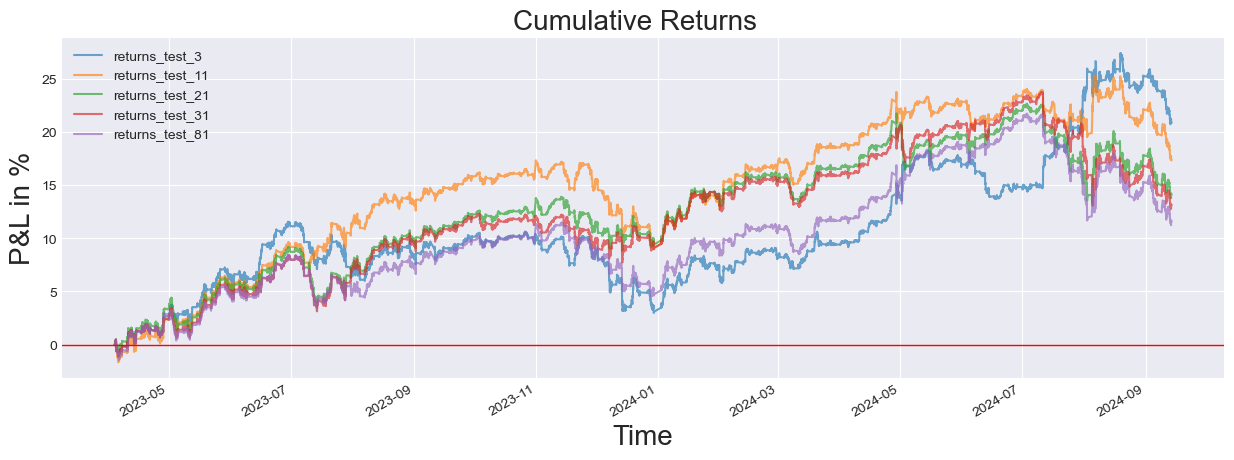

In [6576]:
display.plot_test_returns(returns_df[["returns_test_3","returns_test_11","returns_test_21","returns_test_31","returns_test_81"]])

**The best performing model on throughout the whole predictions based on "returns/drawdown" metric is the model 3**

Plotting the returns obtained with model 3

Profits : 20.89%


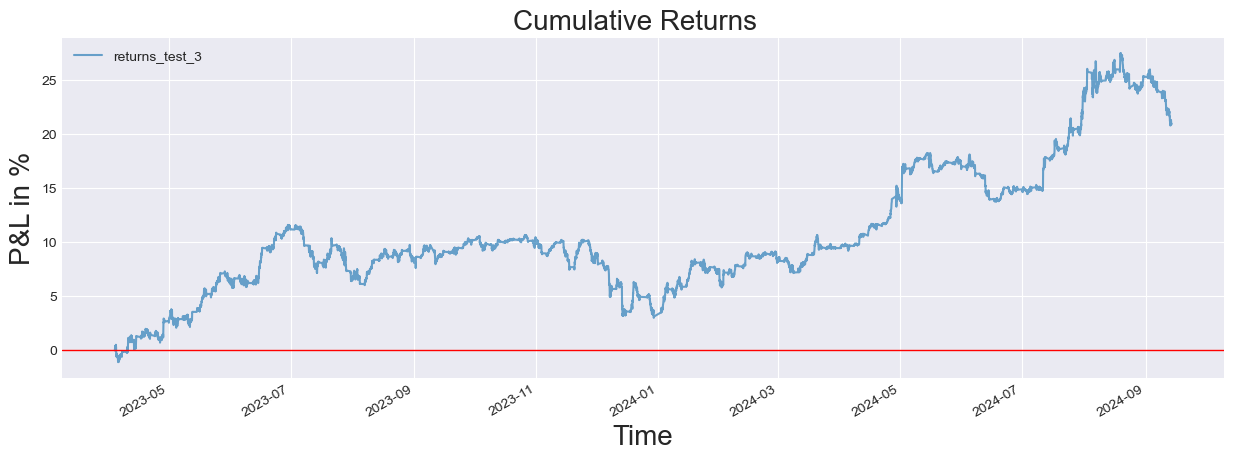

In [6564]:
display.plot_test_returns(returns_df["returns_test_3"])

## Ensemble Model (Bagging)

**Combining the outputs of the best-performing models:**
- One based on the **returns/drawdown** metric, tested only on the **"test_returns"** dataset. **Model_11**
- One based on running the TensorFlow evaluation method, sorted by the **Loss** metric. **Model_21**
- One based on the **returns/drawdown** metric, tested on the entire **"returns_df"** dataset, which includes the full predicted period. **Model_3**

In [6606]:
# Creatring a DataFrame with the final position from the combination of 3 best-performing models 
final_position_df = pd.DataFrame(positions_df[["position_test_11", "position_test_21", "position_test_3"]])
final_position_df["final_position"] = final_position_df.sum(axis=1)
final_position_df["final_position"] = np.where(final_position_df["final_position"] > 0, 1, -1)
final_position_df.head()

,position_test_11,position_test_21,position_test_3,final_position
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


**Forecast Accuracy Analysis for Ensemble Model**

Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    4633
0    4392
Name: count, dtype: int64

Model has an accuracy of: 51.34%


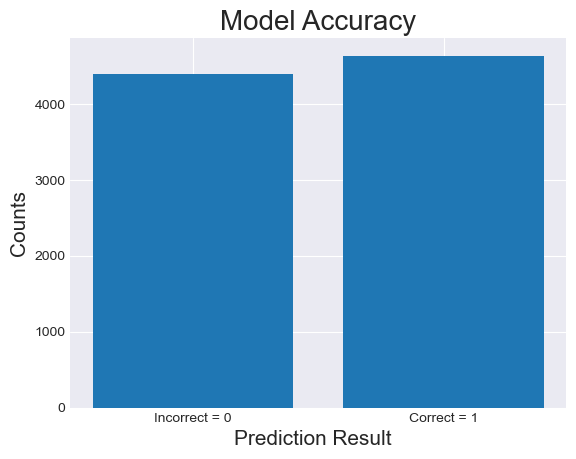

,real_position,pred_position,accuracy
0,1.0,1,1
1,-1.0,1,0
2,-1.0,1,0
3,1.0,1,1
4,1.0,1,1


In [6597]:
backtest.compute_model_accuracy(np.sign(y_test[5:].values), final_position_df["final_position"])

**Confusion Matrix of the Ensemble Model**

In [6616]:
confusion_matrix(np.sign(y_test[5:].values), final_position_df["final_position"])

array([[ 301,    0, 4036],
       [   2,    0,   43],
       [ 311,    0, 4332]], dtype=int64)

**Computing the returns from the Ensemble Model**

In [6604]:
final_returns_df = pd.DataFrame(y_test[5:], columns=["pct_change"])
final_returns_df["final_returns"] = final_returns_df["pct_change"] * final_position_df["final_position"].values
final_returns_df.head()

,pct_change,final_returns
time,,
2023-04-04 00:00:00,0.000053,0.000053
2023-04-04 01:00:00,-0.000446,-0.000446
2023-04-04 02:00:00,-0.000227,-0.000227
2023-04-04 03:00:00,0.001769,0.001769
2023-04-04 04:00:00,0.001728,0.001728


Profits : 16.00%


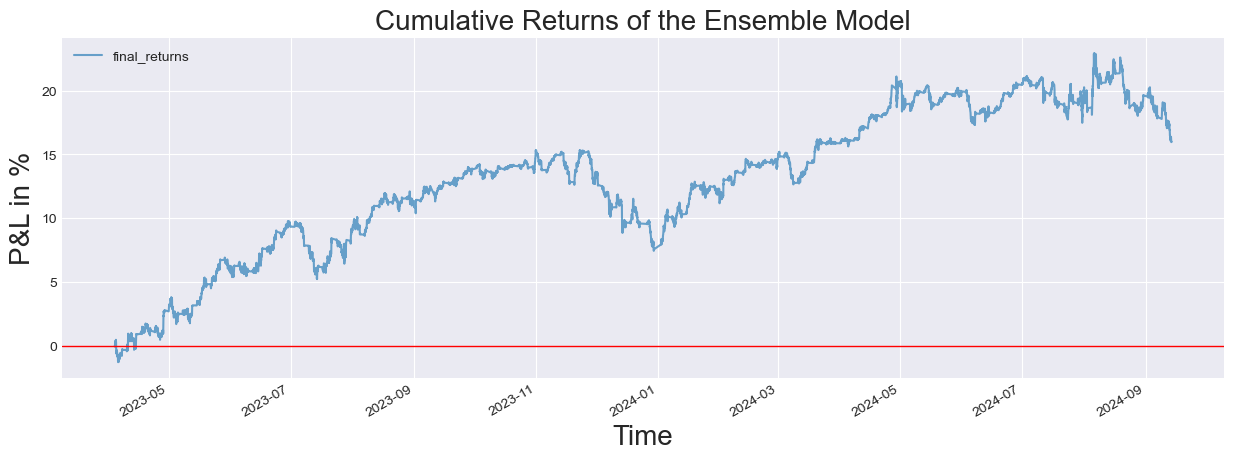

In [6622]:
display.plot_test_returns(final_returns_df["final_returns"], name="of the Ensemble Model")

**Strategy Drawdown from Ensemble Model**

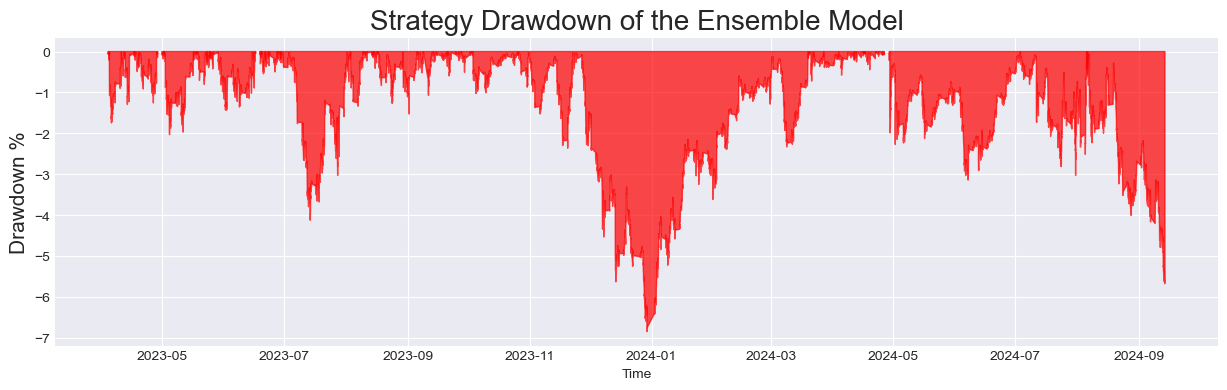

Max Drawdown: -6.84%


In [6624]:
display.plot_drawdown(final_returns_df["final_returns"], name="of the Ensemble Model")